# Lab 2: Polynomial Regression
Covered Topics:
> Polynomial Regression

> Stochastic Gradient Descent

> Normalization of data and Feature Scaling

> Bayesian Information Criterion (BIC)

# Motivation

> Try to implement various training methods for polynomial regression.

> Implement commonly-used data normalization methods and check their influences on the mean-square-error (MSE) of testing data.

> Quantitatively analyze the influence of the polynomial’s order on the model complexity and the learning results.

# Data Simulator and Testing Function (Don't change them)

In [156]:
import numpy as np
import matplotlib.pyplot as plt
# don't add any other packages



def polynomial_data_simulator(n_train: int = 50,
                              n_test: int = 10,
                              order: int = 5,
                              v_noise: float = 2,
                              r_seed: int = 42) -> dict:
    """
    Simulate the training and testing data generated by a polynomial model
    :param n_train: the number of training data
    :param n_test: the number of testing data
    :param order: the order of the polynomial function
    :param v_noise: the variance of noise
    :param r_seed: the random seed
    :return:
        a dictionary containing training set, testing set, and the ground truth parameters
    """
    x_train = 4 * (np.random.RandomState(r_seed).rand(n_train) - 0.5)
    X_train = np.array([x_train ** d for d in range(order)]).T
    x_test = 5 * (np.random.RandomState(r_seed).rand(n_test) - 0.5)
    X_test = np.array([x_test ** d for d in range(order)]).T
    weights = np.random.RandomState(r_seed).randn(order, 1)
    y_train = X_train @ weights + v_noise * np.random.RandomState(r_seed).randn(n_train, 1)
    y_test = X_test @ weights + v_noise * np.random.RandomState(r_seed).randn(n_test, 1)
    data = {'train': [x_train, y_train],
            'test': [x_test, y_test],
            'real': weights}
    return data


def visualization_curves(weights: np.ndarray, label: str, curve_type: str):
    landmarks = 5 * (np.arange(0, 100) / 100 - 0.5)
    order = weights.shape[0]
    curve = np.array([landmarks ** d for d in range(order)]).T @ weights
    plt.plot(landmarks, curve, curve_type, label=label)


def visualization_points(x: np.ndarray, y: np.ndarray, label: str, point_type: str):
    plt.plot(x, y, point_type, label=label)


def testing(x: np.ndarray, y: np.ndarray, weights: np.ndarray) -> float:
    """
    Compute the MSE of regression based on current model
    :param x: testing data with size (N, )
    :param y: testing label with size (N, 1)
    :param weights: model parameter with size (D, 1)
    :return:
        MSE
    """
    order = weights.shape[0]
    x_test = np.array([x ** d for d in range(order)]).T
    y_est = x_test @ weights
    return np.sum((y - y_est) ** 2) / x.shape[0]

# Task 1
Given the problem
$$
\min_{\boldsymbol{w}}\|\boldsymbol{y-X w}\|_{2}^{2}
$$
where $\boldsymbol{X}=\{x_n^{d-1}\}_{n,d=1}^{N,D}\in \mathbb{R}^{N\times D}$ is the Vandermonde matrix, implement the function “training” to achieve its closed-form solution.

## Solution 1
$$
L=\|\boldsymbol{y-Xw}\|^2_2=(\boldsymbol{y-Xw})^\top (\boldsymbol{y-Xw})=\boldsymbol{y^\top y -y^\top Xw-w^\top X^\top y+w^\top X^\top X w}
$$
The F.O.C. is
$$
\dfrac{\partial L}{\partial \boldsymbol{w}}=\boldsymbol{-2X^\top y+2X^\top Xw}=0\Rightarrow \boldsymbol{w}=\boldsymbol{(X^\top X)^{-1}X^\top y}
$$





In [157]:
def training(x: np.ndarray, y: np.ndarray, order: int) -> np.ndarray:
    """
    The training function of polynomial regression model
    :param x: input data with size (N,)
    :param y: labels of data with size (N, 1)
    :param order: the hyper-parameter determining the order of the polynomial function
    :return:
        a weight vector with size (D, 1), D is the order of polynomial function.
    """
    # TODO: Change the code below and implement the closed-form solution of polynomial regression
    # (X^T X)^-1 X^T y
    X = np.array([x ** d for d in range(order)]).T
    return np.linalg.inv(X.T @ X) @ X.T @ y

A little example that examines our correctiveness.

In [158]:
x = np.arange(100)+1
y = (2*x).reshape(-1,1)
X = np.array([x**d for d in range(5)]).T
w = training(x,y,5)

y,X,w

(array([[  2],
        [  4],
        [  6],
        [  8],
        [ 10],
        [ 12],
        [ 14],
        [ 16],
        [ 18],
        [ 20],
        [ 22],
        [ 24],
        [ 26],
        [ 28],
        [ 30],
        [ 32],
        [ 34],
        [ 36],
        [ 38],
        [ 40],
        [ 42],
        [ 44],
        [ 46],
        [ 48],
        [ 50],
        [ 52],
        [ 54],
        [ 56],
        [ 58],
        [ 60],
        [ 62],
        [ 64],
        [ 66],
        [ 68],
        [ 70],
        [ 72],
        [ 74],
        [ 76],
        [ 78],
        [ 80],
        [ 82],
        [ 84],
        [ 86],
        [ 88],
        [ 90],
        [ 92],
        [ 94],
        [ 96],
        [ 98],
        [100],
        [102],
        [104],
        [106],
        [108],
        [110],
        [112],
        [114],
        [116],
        [118],
        [120],
        [122],
        [124],
        [126],
        [128],
        [130],
        [132],
        [1

# Task 2

Given the problem in (1), implement the function “training_sgd” to learn the model via stochastic gradient descent (SGD).

## Solution 2
[Note]: 'Epoch' means number of iteration.

Process of SGD is described as follows
> Initialize $\boldsymbol{w}^{(0)}$ randomly.

> At iteration $t$, sample a batch of data $\{\boldsymbol{x}_i,y_i\}_{i=1}^B$ randomly.

> Compute the gradient $\dfrac{\partial L}{\partial \boldsymbol{w}}=2\boldsymbol{X}^\top_B(\boldsymbol{X}_B\boldsymbol{w}_{t-1}-\boldsymbol{y}_B)$.

> Update $\boldsymbol{w}_t=\boldsymbol{w}_{t-1}-\tau \dfrac{\partial L}{\partial \boldsymbol{w}}$.

In actual realization of SGD, do not forget to **divide gradience by `batch_size` each time, as this averages the gradience computed under each `(y_batch, X_batch)` so that we can get a more accurate gradience each time.**

Polynomial features, especially for higher orders, can cause large variance in the input data range. Each successive power of a base increases the range of that feature, which can **lead to very large values in both the feature matrix and the subsequent gradients**.
> If we set `order>=3` in SGD-optimized `w`, we will see that both gradience under each batch and weight `w` explodes.

In [159]:
def training_sgd(x: np.ndarray,
                 y: np.ndarray,
                 order: int,
                 epoch: int = 10,
                 batch_size: int = 10,
                 lr: float = 1e-4,
                 r_seed: int = 42) -> np.ndarray:
    """
    The stochastic gradient descent method
    :param x: input data with size (N,)
    :param y: labels of data with size (N, 1)
    :param order: the hyper-parameter determining the order of the polynomial function
    :param epoch: the number of epochs
    :param batch_size: the batch size for sgd
    :param lr: the learning rate
    :param r_seed: random seed
    :return:
        a weight vector with size (D, 1)
    """
    # TODO: Change the code below and implement the SGD algorithm of polynomial regression  
    np.random.seed(r_seed)
    # The length of dataset: n
    n = len(x)
    # Vandermonde Matrix
    X = np.array([x ** d for d in range(order)]).T
    
    # Step1: Initial weight w randomly
    w = np.random.rand(order).reshape(order,1)

    # Step2: At iteration t, sample a batch of data {x_i,y_i} (i=1...B) randomly.
    for e in range(epoch):
        # Get the random permutation of 1 to n to shuffle X at each epoch
        idx = np.random.permutation(n)
        X = X[idx]
        y = y[idx]
        # Step size is batch_size
        for i in range(0, n, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            # Calculate the gradient and normalize it by dividing batch_size
            grad = 2 * (X_batch.T @ (X_batch @ w - y_batch)) / batch_size
            w -= lr * grad
            # Debugging: to check our gradience each time
            # print(f"Epoch {e}, Batch {i//batch_size}: Norm of gradients: {np.linalg.norm(grad)}")
    return w

A little example that examines our correctiveness.

In [160]:
w = training_sgd(x,y,order=2,epoch=10000,lr=1e-5)
y,X,w

(array([[  2],
        [  4],
        [  6],
        [  8],
        [ 10],
        [ 12],
        [ 14],
        [ 16],
        [ 18],
        [ 20],
        [ 22],
        [ 24],
        [ 26],
        [ 28],
        [ 30],
        [ 32],
        [ 34],
        [ 36],
        [ 38],
        [ 40],
        [ 42],
        [ 44],
        [ 46],
        [ 48],
        [ 50],
        [ 52],
        [ 54],
        [ 56],
        [ 58],
        [ 60],
        [ 62],
        [ 64],
        [ 66],
        [ 68],
        [ 70],
        [ 72],
        [ 74],
        [ 76],
        [ 78],
        [ 80],
        [ 82],
        [ 84],
        [ 86],
        [ 88],
        [ 90],
        [ 92],
        [ 94],
        [ 96],
        [ 98],
        [100],
        [102],
        [104],
        [106],
        [108],
        [110],
        [112],
        [114],
        [116],
        [118],
        [120],
        [122],
        [124],
        [126],
        [128],
        [130],
        [132],
        [1

# Task 3

Given the above data matrix $X = [\boldsymbol{x_1}, \cdots, \boldsymbol{x_D}]$, implement different normalization strategies:
$$
\boldsymbol{\tilde X}=\boldsymbol{X}\text{diag}(\boldsymbol{a}), \boldsymbol{a}=\left[\dfrac{1}{\|\boldsymbol{x_1}\|_p},\cdots,\dfrac{1}{\|\boldsymbol{x_D}\|_p}\right]^\top, p=1,2,\infty
$$
where $\boldsymbol{a}$ is called scaling vector, and $\text{diag}(\cdot)$ means converting a vector to a diagonal matrix.


## Solution 3

We will use the following functions to implement data normalization
> `np.reciprocal(arr)` returns the reciprocal of given array `arr`

> `np.linalg.norm(X, axis=0)` returns the norm of each column in matrix `X`$\in \mathbb{R}^{N\times D}$.

In [161]:
X = np.array([x ** d for d in range(4)]).T
np.linalg.norm(X, axis=0)
# L2 norm
reciprocal = np.reciprocal(np.linalg.norm(X, ord=2, axis=0))
np.linalg.norm(X, ord=2, axis=0), reciprocal

(array([1.00000000e+01, 5.81678605e+02, 4.52806066e+04, 3.84586975e+06]),
 array([1.00000000e-01, 1.71916242e-03, 2.20845098e-05, 2.60019206e-07]))

In [162]:
# Task 3: Implement various data normalization method.
def data_normalization(x: np.ndarray, order: int, method: str = 'L2') -> [np.ndarray, np.ndarray]:
    """
    implement various data_normalization method
    :param x: input data with size (N, )
    :param order: the hyper-parameter determining the order of the polynomial function
    :param method: 'L2': ensure the L2-norm of each column of data matrix is 1
                   'L1': ensure the L1-norm of each column of data matrix is 1
                   'Max': ensure the Infinity-norm of each column of data matrix is 1
    :return:
        A data matrix with size (N, D), each column is normalized according to the method we set
        A scaling vector containing the norms of original columns, with size (D, )
    """
    X = np.array([x ** d for d in range(order)]).T
    if method == 'L2':
        a = np.reciprocal(np.linalg.norm(X, ord=2, axis=0))
    elif method == 'L1':
        a = np.reciprocal(np.linalg.norm(X, ord=1, axis=0))
    elif method == 'Max':
        a = np.reciprocal(np.linalg.norm(X, ord=np.inf, axis=0))
    else:
        raise ValueError("Invalid method")
    return X @ np.diag(a), a

# Task 4
Achieve a SGD algorithm based on the normalized data and implement a testing method for the model trained on the normalized data.

## Solution 4
 We only need to modify `X` into `X_normalized` in the `training_sgd` function to get `training_sgd_normalized`.

In [163]:
def training_sgd_normalized(x: np.ndarray,
                            y: np.ndarray,
                            order: int,
                            epoch: int = 10,
                            batch_size: int = 10,
                            lr: float = 1e-4,
                            method: str = 'L2',
                            r_seed: int = 42) -> [np.ndarray, np.ndarray]:
    """
        The stochastic gradient descent method
        :param x: input data with size (N,)
        :param y: labels of data with size (N, 1)
        :param order: the hyper-parameter determining the order of the polynomial function
        :param epoch: the number of epochs
        :param batch_size: the batch size for sgd
        :param lr: the learning rate
        :param method: the data normalization method (L2, L1, or Max)
        :param r_seed: random seed
        :return:
            A weight vector with size (D, 1)
            A scaling vector containing the norms of original columns, with size (D, )
    """
    np.random.seed(r_seed)
    n = len(x)
    X_normalized, a = data_normalization(x, order, method)
    
    w = np.random.rand(order).reshape(order,1)
    for e in range(epoch):
        idx = np.random.permutation(n)
        X = X_normalized[idx]
        y = y[idx]
        for i in range(0, n, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            grad = 2 * (X_batch.T @ (X_batch @ w - y_batch)) / batch_size
            w -= lr * grad
    return w, a

A natural testing method is to compute the MSE of the testing data, i.e. $\dfrac{1}{N}\|\boldsymbol{y_{\text{test}}-\boldsymbol{X_{\text{test}}w}}\|^2_2$.

In [164]:
def testing_normalized(x: np.ndarray, y: np.ndarray, weights: np.ndarray, scaling: np.ndarray) -> float:
    """
    Compute the MSE of regression based on current model
    :param x: testing data with size (N, )
    :param y: testing label with size (N, 1)
    :param weights: model parameter with size (D, 1)
    :param scaling: A scaling vector containing the norms of original columns, with size (D, )
    :return:
        MSE
    """
    order = weights.shape[0]
    X = np.array([x ** d for d in range(order)]).T
    X_normalized = X @ np.diag(scaling)
    y_est = X_normalized @ weights
    return np.sum((y - y_est) ** 2) / x.shape[0]

# Task 5
Implement the Bayesian information criterion (BIC) value for model selection (For each model, we assume that the noise imposed on the model is $\mathcal{N}(0, 1)$ and the model is trained based on **unnormalized data**).

## Solution 5

Recall that BIC is defined as:
$$
BIC = K \cdot\log N - 2 \cdot  \log\hat L
$$
where $N$ is the number of data points, $K$ is the number of parameters, and $L$ is the likelihood of the model:
$$
\hat L = \exp\left(-\dfrac{\|\boldsymbol{y-Xw}\|^2_2}{2\sigma^2}\right)
$$
Note that here noise follows $\mathcal{N}(0,1)$, so $\sigma^2=1$.

In [167]:
def bayesian_information_criterion(x: np.ndarray, y: np.ndarray, weights: np.ndarray):
    """
    Compute the BIC value for model selection
    :param x: testing data with size (N, )
    :param y: testing label with size (N, 1)
    :param weights: model parameter with size (D, 1)
    :return:
    """
    order = weights.shape[0]
    X = np.array([x ** d for d in range(order)]).T
    sigma = 1
    # BIC = K * log(N) - 2 * log(L)
    # K refers to the number of parameters in the model, i.e. polynomial order
    K = weights.shape[0]
    # N refers to the number of training samples
    N = x.shape[0]
    # L refers to the likelihood of the model (Normal Distribution)
    L = np.exp(-1 / (2 * sigma**2 ) * np.sum((y - X @ weights) ** 2))
    return K * np.log(N) - 2 * np.log(L)

# Test Script


Order=3, mse1=11.8607, mse2=53.6114, mse3=68.3761, BIC=125.5143


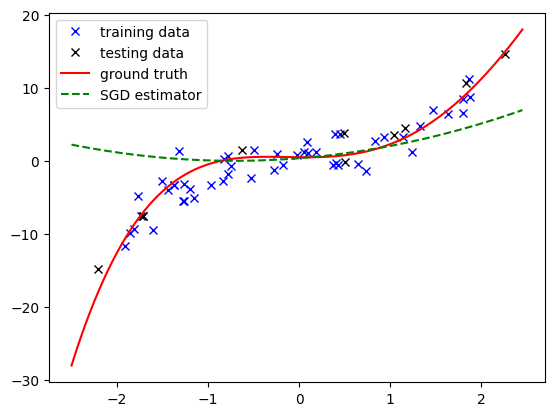

Order=5, mse1=1.9595, mse2=18.1296, mse3=65.5682, BIC=31.1078


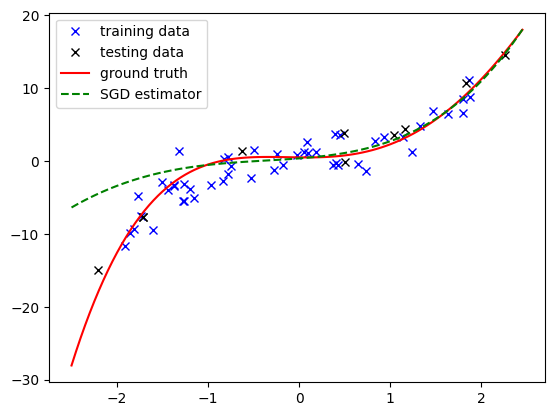

Order=7, mse1=21.1623, mse2=10.9252, mse3=64.7738, BIC=227.7411


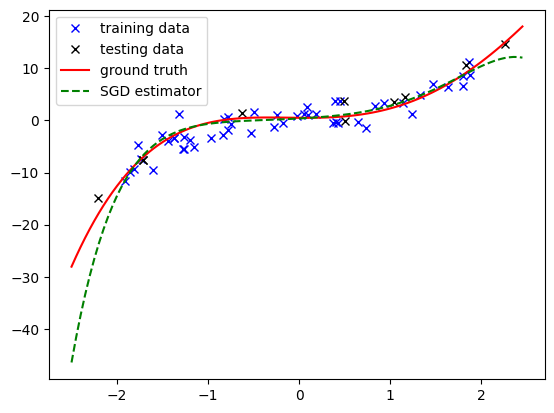

Order=9, mse1=28.7903, mse2=36.5265, mse3=65.9540, BIC=308.6264


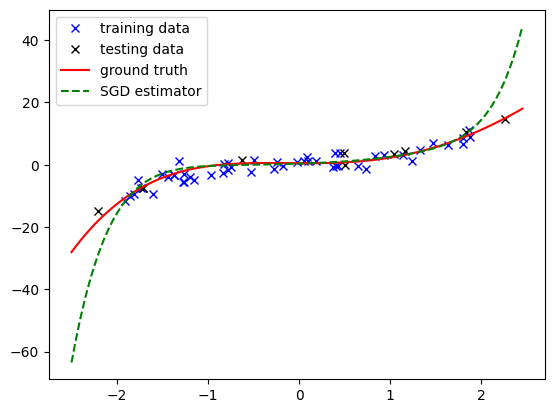

In [168]:
data = polynomial_data_simulator()
orders = [3, 5, 7, 9]
for i in range(len(orders)):
    w_est1 = training(x=data['train'][0], y=data['train'][1], order=orders[i])
    w_est2 = training_sgd(x=data['train'][0], y=data['train'][1], order=orders[i])
    w_est3, scales = training_sgd_normalized(x=data['train'][0], y=data['train'][1], order=orders[i])
    mse1 = testing(x=data['test'][0], y=data['test'][1], weights=w_est1)
    bic = bayesian_information_criterion(x=data['test'][0], y=data['test'][1], weights=w_est1)
    mse2 = testing(x=data['test'][0], y=data['test'][1], weights=w_est2)
    mse3 = testing_normalized(x=data['test'][0], y=data['test'][1], weights=w_est2, scaling=scales)
    print('Order={}, mse1={:.4f}, mse2={:.4f}, mse3={:.4f}, BIC={:.4f}'.format(orders[i], mse1, mse2, mse3, bic))
    plt.figure()
    visualization_points(x=data['train'][0], y=data['train'][1][:, 0], point_type='bx', label='training data')
    visualization_points(x=data['test'][0], y=data['test'][1][:, 0], point_type='kx', label='testing data')
    visualization_curves(weights=data['real'], label='ground truth', curve_type='r-')
    visualization_curves(weights=w_est2, label='SGD estimator', curve_type='g--')
    plt.legend()
    plt.show()